# Experiment 5: Sentiment Analysis on Twitter using KNN

**Objective:**  
Build a complete pipeline for sentiment classification of tweets using K-Nearest Neighbors (KNN). This notebook includes extensive theory, preprocessing, feature extraction (TF-IDF), model selection (GridSearch), evaluation, visualizations, and saving artifacts.

---

## Extensive Theory

### 1. Sentiment Analysis Overview
Sentiment analysis (opinion mining) is the automated process of determining whether a piece of text is positive, negative, or neutral. It is widely used in social media monitoring, customer feedback analysis, and market research. Approaches vary from lexicon-based methods to supervised machine learning and deep learning.

### 2. Why KNN for Text Classification?
KNN is a non-parametric, instance-based learning algorithm. For classification, it finds the K nearest labeled examples in the feature space and predicts the majority class among them. Advantages and disadvantages are discussed in the notebook.

### 3. Feature Extraction: TF-IDF
Term Frequency-Inverse Document Frequency (TF-IDF) transforms text into a numeric representation that emphasizes words that are frequent in a document but rare across the corpus. TF-IDF is suitable for KNN because it creates a vector space where distance corresponds to document similarity.

### 4. Preprocessing Choices and Their Impact
Key preprocessing steps and why they matter: lowercasing, URL/mention removal, hashtag handling, stopword removal, stemming/lemmatization, and n-grams.

### 5. Model Selection for KNN
KNN hyperparameters to tune: n_neighbors (K), weights, and metric. Use GridSearchCV to find best parameters.

### 6. Evaluation & Visualizations
Confusion matrix, classification report, per-class word clouds, and most informative features (approximation) are included.


### Install & Import Libraries (run in Colab)

In [5]:
# If running in Colab, uncomment the following if packages are missing:
!pip install -U scikit-learn nltk wordcloud joblib

import os, re
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from google.colab import files
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab') # Add this line to download the missing resource

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

### Upload your labeled Twitter CSV

In [2]:

print('Please upload a CSV file with columns: text, label (label as 0/1 or neg/pos).')
uploaded = files.upload()
df = None
for fn in uploaded.keys():
    df = pd.read_csv(fn)
    print('Loaded', fn, 'shape=', df.shape)
    break

if df is not None:
    display(df.head())
else:
    print('No file uploaded. You can run the sample dataset cell to create a small labeled CSV.')


Please upload a CSV file with columns: text, label (label as 0/1 or neg/pos).


Saving sample_tweets_labeled.csv..txt to sample_tweets_labeled.csv..txt
Loaded sample_tweets_labeled.csv..txt shape= (16, 2)


,text,label
0,I love watching football on weekends! #sports,positive
1,The new iPhone launch is amazing... #AppleEvent,positive
2,Feeling sad about the current world events :(,negative
3,Machine learning is the future of AI.,positive
4,This movie was absolutely fantastic!! :),positive


### Create & Download a Small Sample Labeled Dataset

In [6]:

# Create a small labeled dataset for quick testing and demonstration.
sample_data = {
    'text':[
        'I love this product, works great and I am very happy',
        'Terrible experience, will never buy again. Very disappointed',
        'Amazing service and friendly staff, highly recommend!',
        'Worst purchase ever. Do not waste your money.',
        'I am so pleased with the new update, it is awesome',
        'I hate this, it broke within days and support was useless',
        'The movie was fantastic, enjoyed every moment',
        'Not good, the product stopped working after one use',
        'Very satisfied with the delivery and customer care',
        'Extremely unhappy, the item arrived damaged and late'
    ],
    # Labels: 1 = positive, 0 = negative
    'label':[1,0,1,0,1,0,1,0,1,0]
}
sample_df = pd.DataFrame(sample_data)
sample_df.to_csv('sample_tweets_labeled.csv', index=False)
print('Created sample_tweets_labeled.csv (10 samples). Upload this file if you want to test the notebook quickly.')
sample_df.head()


Created sample_tweets_labeled.csv (10 samples). Upload this file if you want to test the notebook quickly.


,text,label
0,"I love this product, works great and I am very...",1
1,"Terrible experience, will never buy again. Ver...",0
2,"Amazing service and friendly staff, highly rec...",1
3,Worst purchase ever. Do not waste your money.,0
4,"I am so pleased with the new update, it is awe...",1


### Cell: Preprocessing — Theory

Key preprocessing steps performed in next cell:
- Lowercasing
- Remove URLs, mentions, hashtags (or keep hashtag words)
- Remove punctuation and digits
- Tokenize
- Remove stopwords (optionally keep negations)
- Stemming (Porter Stemmer)

We will produce a `clean_text` column used for TF-IDF vectorization.

In [7]:

ps = PorterStemmer()
stop_words = set(stopwords.words('english'))
# Optionally keep negation words for sentiment e.g., 'not'
# stop_words.discard('not')

def clean_text(text, keep_hashtag_word=True):
    if not isinstance(text, str):
        return ''
    text = text.lower()
    text = re.sub(r'http\S+|www\S+', ' ', text)
    text = re.sub(r'@[A-Za-z0-9_]+', ' ', text)
    if keep_hashtag_word:
        text = re.sub(r'#', '', text)
    else:
        text = re.sub(r'#[A-Za-z0-9_]+', ' ', text)
    text = re.sub(r'[^a-z\s]', ' ', text)
    tokens = nltk.word_tokenize(text)
    tokens = [ps.stem(t) for t in tokens if t not in stop_words and len(t)>1]
    return ' '.join(tokens)

if 'df' in globals() and df is not None:
    df['clean_text'] = df['text'].astype(str).apply(clean_text)
    display(df[['text','clean_text','label']].head())
else:
    print('No dataframe loaded. Upload your labeled CSV or create the sample CSV and upload it.')


,text,clean_text,label
0,I love watching football on weekends! #sports,love watch footbal weekend sport,positive
1,The new iPhone launch is amazing... #AppleEvent,new iphon launch amaz appleev,positive
2,Feeling sad about the current world events :(,feel sad current world event,negative
3,Machine learning is the future of AI.,machin learn futur ai,positive
4,This movie was absolutely fantastic!! :),movi absolut fantast,positive


### Exploratory Data Analysis (Class Distribution, WordClouds)

Class distribution:


,label,counts
0,positive,9
1,negative,5
2,neutral,2


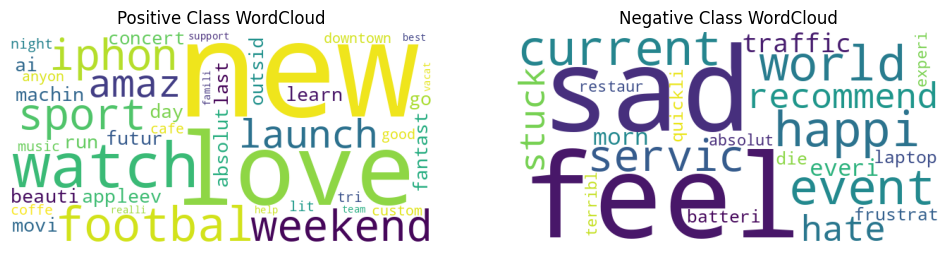

In [10]:
if 'df' in globals() and df is not None:
    print('Class distribution:')
    display(df['label'].value_counts().rename_axis('label').reset_index(name='counts'))

    # WordClouds per class
    pos_text = ' '.join(df[df['label']=='positive']['clean_text'].astype(str).tolist())
    neg_text = ' '.join(df[df['label']=='negative']['clean_text'].astype(str).tolist())

    from wordcloud import WordCloud
    wc_pos = WordCloud(width=600, height=300, background_color='white').generate(pos_text)
    wc_neg = WordCloud(width=600, height=300, background_color='white').generate(neg_text)

    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1); plt.imshow(wc_pos); plt.title('Positive Class WordCloud'); plt.axis('off')
    plt.subplot(1,2,2); plt.imshow(wc_neg); plt.title('Negative Class WordCloud'); plt.axis('off')
    plt.show()
else:
    print('No dataframe loaded.')

### TF-IDF Vectorization & Train/Test Split

In [12]:

if 'df' in globals() and df is not None:
    X = df['clean_text'].astype(str)
    y = df['label'].values
    vect = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
    X_tfidf = vect.fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42, stratify=y)
    print('TF-IDF shape:', X_tfidf.shape)
else:
    print('No dataframe loaded.')


TF-IDF shape: (16, 131)


### Hyperparameter Tuning for KNN (GridSearchCV)

In [13]:

if 'X_train' in globals():
    # Use cosine metric or euclidean
    param_grid = {'n_neighbors':[1,3,5,7,9], 'weights':['uniform','distance'], 'metric':['cosine','euclidean']}
    knn = KNeighborsClassifier()
    grid = GridSearchCV(knn, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
    grid.fit(X_train, y_train)
    print('Best params:', grid.best_params_)
    best_knn = grid.best_estimator_
else:
    print('X_train not found. Run TF-IDF & split cell.')


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


Best params: {'metric': 'cosine', 'n_neighbors': 1, 'weights': 'uniform'}


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_search.py:1135: UserWarning: One or more of the test scores are non-finite: [0.58333333 0.58333333 0.41666667 0.41666667 0.41666667 0.41666667
 0.41666667 0.41666667        nan        nan 0.5        0.5
 0.25       0.58333333 0.33333333 0.33333333 0.41666667 0.41666667
        nan        nan]
  warnings.warn(


### Evaluate Best KNN on Test Set

Accuracy: 0.25

Classification Report:
               precision    recall  f1-score   support

    negative       0.00      0.00      0.00         1
     neutral       0.00      0.00      0.00         1
    positive       0.50      0.50      0.50         2

    accuracy                           0.25         4
   macro avg       0.17      0.17      0.17         4
weighted avg       0.25      0.25      0.25         4

Confusion Matrix:
 [[0 0 1]
 [1 0 0]
 [0 1 1]]


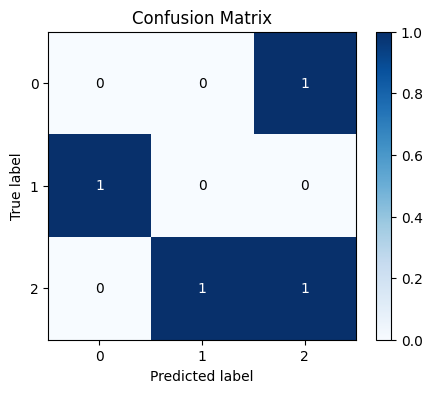

In [14]:

if 'best_knn' in globals() and 'X_test' in globals():
    preds = best_knn.predict(X_test)
    print('Accuracy:', accuracy_score(y_test, preds))
    print('\nClassification Report:\n', classification_report(y_test, preds))
    cm = confusion_matrix(y_test, preds)
    print('Confusion Matrix:\n', cm)

    # Plot confusion matrix heatmap
    plt.figure(figsize=(5,4))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(np.unique(y)))
    plt.xticks(tick_marks, tick_marks)
    plt.yticks(tick_marks, tick_marks)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, cm[i,j], ha='center', va='center', color='white' if cm[i,j]>cm.max()/2 else 'black')
    plt.show()
else:
    print('Model not trained or X_test missing.')


### Approximate Most Informative Features per Class (via average TF-IDF)

In [15]:

if 'vect' in globals() and 'X_tfidf' in globals() and 'y' in globals():
    feature_names = vect.get_feature_names_out()
    X_array = X_tfidf.toarray()
    pos_mean = X_array[y==1].mean(axis=0)
    neg_mean = X_array[y==0].mean(axis=0)
    top_pos_idx = np.argsort(pos_mean)[-20:][::-1]
    top_neg_idx = np.argsort(neg_mean)[-20:][::-1]
    print('Top positive tokens:', [feature_names[i] for i in top_pos_idx[:20]])
    print('Top negative tokens:', [feature_names[i] for i in top_neg_idx[:20]])
else:
    print('Run TF-IDF cell first.')


Top positive tokens: ['event', 'ever', 'ever famili', 'everi', 'everi morn', 'experi', 'experi restaur', 'famili', 'fantast', 'feel', 'feel new', 'feel sad', 'footbal', 'footbal weekend', 'frustrat', 'absolut', 'futur ai', 'get', 'get stuck', 'go']
Top negative tokens: ['event', 'ever', 'ever famili', 'everi', 'everi morn', 'experi', 'experi restaur', 'famili', 'fantast', 'feel', 'feel new', 'feel sad', 'footbal', 'footbal weekend', 'frustrat', 'absolut', 'futur ai', 'get', 'get stuck', 'go']


/tmp/ipython-input-667141444.py:4: RuntimeWarning: Mean of empty slice.
  pos_mean = X_array[y==1].mean(axis=0)
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:130: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/tmp/ipython-input-667141444.py:5: RuntimeWarning: Mean of empty slice.
  neg_mean = X_array[y==0].mean(axis=0)


### Save Best Model & Vectorizer

In [16]:

if 'best_knn' in globals() and 'vect' in globals():
    joblib.dump(best_knn, 'knn_sentiment_model.joblib')
    joblib.dump(vect, 'tfidf_vectorizer.joblib')
    print('Saved knn_sentiment_model.joblib and tfidf_vectorizer.joblib')
else:
    print('Model or vectorizer not found.')


Saved knn_sentiment_model.joblib and tfidf_vectorizer.joblib


### Final Notes & Next Steps

- For large datasets use approximate nearest neighbors for speed (Annoy, Faiss).  
- Try other classifiers like Logistic Regression or SVM for comparison.  
- Use cross-validation and stratified sampling for imbalanced datasets.